# GEONE - Variogram analysis and kriging for data in 3D (omni-directional)

Interpolate a data set in 3D, using ordinary kriging. Starting from a data set in 3D, the following is done:

- basic exploratory analysis: variogram cloud / experimental variogram
- fitting a covariance / variogram model, and cross-validation (LOO error)
- interpolation by ordinary kriging (OK), simple kriging (SK)
- sequential gaussian simulation (SGS) based on ordinary or simple kriging

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=13, micro=7, releaselevel='final', serial=0)
geone version: 1.3.0


In [3]:
pv.set_jupyter_backend('static') # static plots
# pv.set_jupyter_backend('trame')  # 3D-interactive plots

## Preparation - build a data set in 3D

A data set in 3D is extracted from a Gaussian random field generated based on a known covariance model, called the *reference model* which will be considered as unknown further.

Define a (isotropic) *reference* covariance model in 1D (class `geone.covModel.CovModel1D`), used as omni-directional in 3D.

*Note: see the notebook `ex_general_multiGaussian.ipynb` for available covariance models and examples.*

In [4]:
cov_model_ref = gn.covModel.CovModel1D(elem=[
    ('spherical', {'w':9.5, 'r':15.}), # elementary contribution (same ranges: isotropic)
    ('nugget', {'w':0.5})                       # elementary contribution
    ], name='ref model (isotropic)')

In [5]:
cov_model_ref

*** CovModel1D object ***
name = 'ref model (isotropic)'
number of elementary contribution(s): 2
elementary contribution 0
    type: spherical
    parameters:
        w = 9.5
        r = 15.0
elementary contribution 1
    type: nugget
    parameters:
        w = 0.5
*****

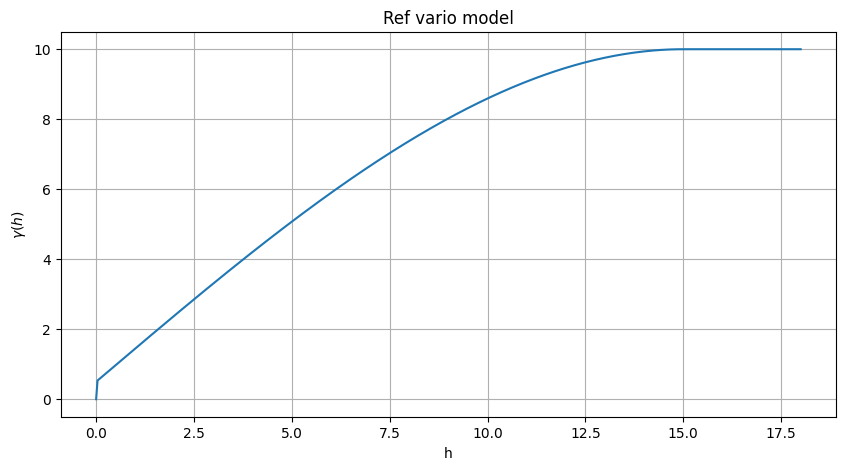

In [6]:
# Plot reference variogram model
plt.figure(figsize=(10,5))
cov_model_ref.plot_model(vario=True)
plt.title('Ref vario model')
plt.show()

Generate a gaussian random field in 3D (see function `geone.grf.grf3D`), and extract data points:

- `n`: number of data points
- `x`: location of data points (2-dimensional array of shape `(n, 3)`, each row is a point)
- `v`: values at data points (1-dimensional array of length `n`)

In [7]:
# Simulation grid (domain)
nx, ny, nz = 65, 64, 60     # number of cells
sx, sy, sz = 0.5, 0.5, 0.5  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

# Reference simulation
np.random.seed(123)
ref = gn.grf.grf3D(cov_model_ref, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz), nreal=1) 
    # 4d-array of shape 1 x nz x ny x nx

im_ref = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=1, val=ref)

# Extract n points from the reference simulation
n = 150 # number of data points
# --- Choose 1. or 2. below ---
# # 1. Sampling the image
# ps = gn.img.sampleFromImage(im_ref, n, seed=234)
# # Data points and data value
# x = np.array((ps.x(), ps.y(), ps.z())).T
# v = ps.val[3]
# # Optionally: move points in the grid cells randomly, and add noise to values
# x[:, 0] = x[:, 0] + (np.random.random(n)-0.5)* im_ref.sx
# x[:, 1] = x[:, 1] + (np.random.random(n)-0.5)* im_ref.sy
# x[:, 2] = x[:, 2] + (np.random.random(n)-0.5)* im_ref.sz
# v = v + (np.random.random(n)-0.5)* 1.e-1

# 2. Using the function interpolating the image values
f = gn.img.Img_interp_func(im_ref)
np.random.seed(658)
x1 = im_ref.xmin() + np.random.random(n) * (im_ref.xmax()-im_ref.xmin())
x2 = im_ref.ymin() + np.random.random(n) * (im_ref.ymax()-im_ref.ymin())
x3 = im_ref.zmin() + np.random.random(n) * (im_ref.zmax()-im_ref.zmin())
x = np.array((x1, x2, x3)).T
v = f(x)
# ----- #

In [8]:
# Preparation for plotting reference simulation and data points

# Color settings
cmap = 'terrain'

cmin = im_ref.vmin()[0] # min value in ref
cmax = im_ref.vmax()[0] # max value in ref

# Get colors for conditioning data according to their value and color settings
data_points_col = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin, cmax=cmax) 

# Set points to be plotted
data_points = pv.PolyData(x)
data_points['colors'] = data_points_col

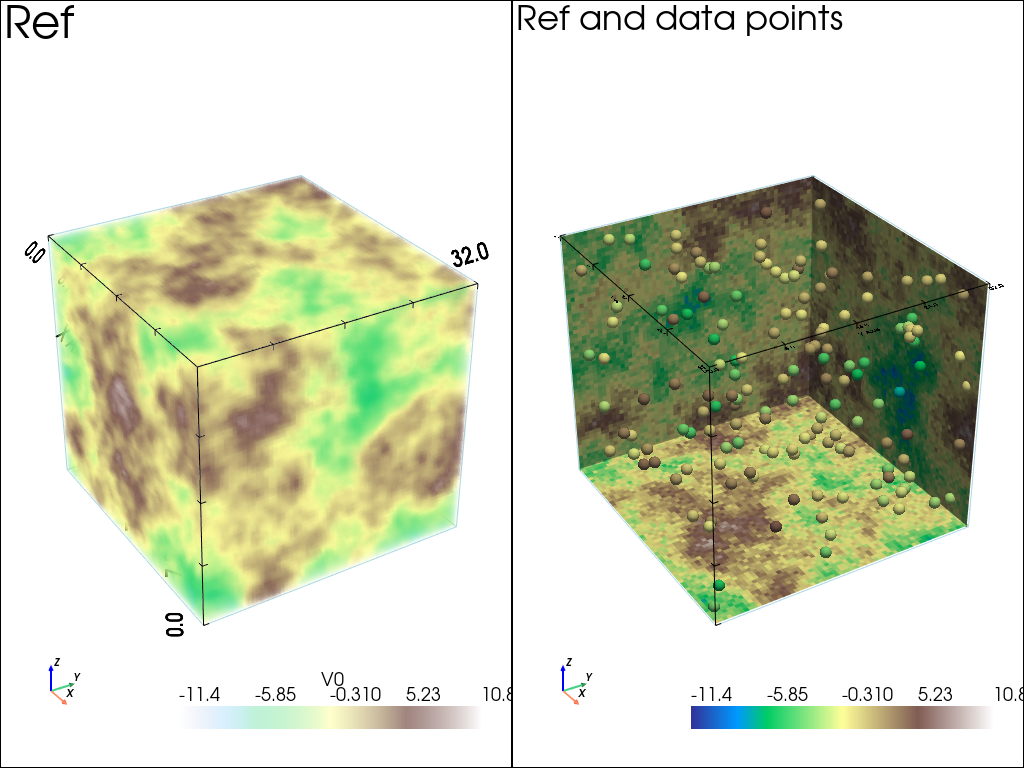

In [9]:
# Plot reference simulation and data points 

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(1,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(1,2))

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_volume(
    im_ref, 
    plotter=pp, 
    cmap=cmap, cmin=cmin, cmax=cmax,
    show_bounds=True, # show axes and ticks around the 3D box
    text='Ref') # title

pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_slice(
    im_ref, 
    plotter=pp, 
    slice_normal_x=ox+0.5*sx,
    slice_normal_y=oy+(ny-0.5)*sy,
    slice_normal_z=oz+0.5*sz,
    cmap=cmap, cmin=cmin, cmax=cmax,
    show_bounds=True, # show axes and ticks around the 3D box
    scalar_bar_kwargs={'title':''}, # distinct title in each subplot for correct display!
    text='Ref and data points')

pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.link_views()

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

## Start from a data set in 3D

- `n`: number of data points
- `x`: location of data points (2-dimensional array of shape `(n, 3)`, each row is a point)
- `v`: values at data points (1-dimensional array of length `n`)

Visualise the data set and the histogram of values.

In [10]:
# Set data_points
data_points = pv.PolyData(x)
data_points['data value'] = v

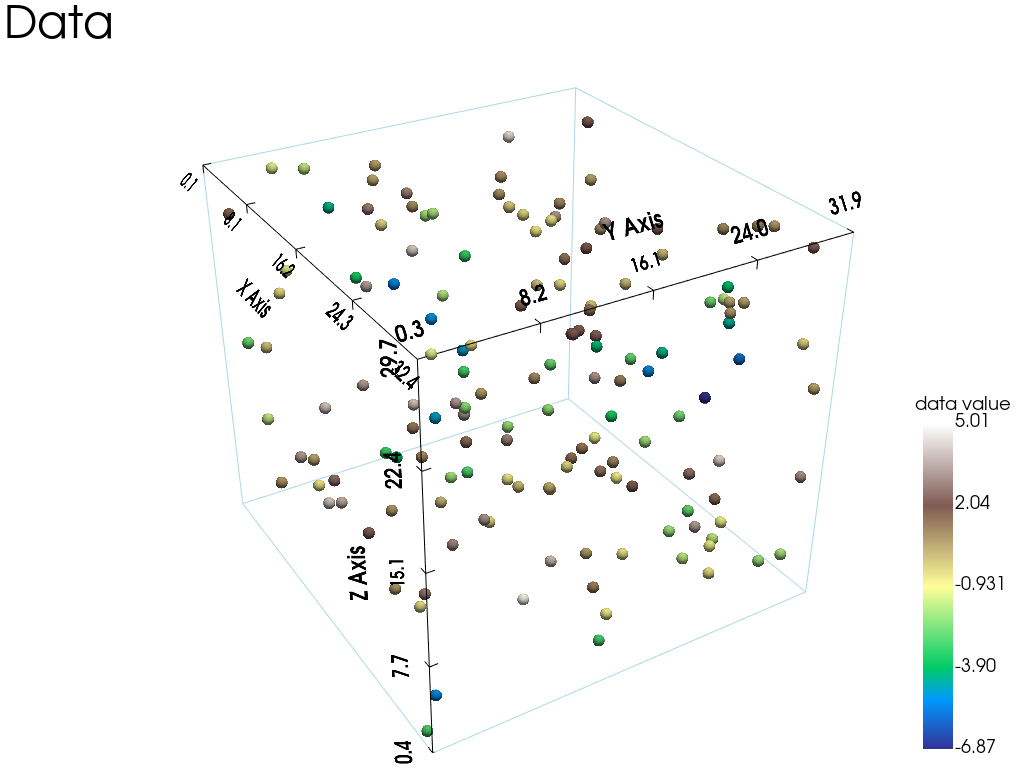

In [11]:
# Plot data points in 3D

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(notebook=False)
# ... inline
pp = pv.Plotter()

pp.add_mesh(data_points, cmap=cmap, point_size=12., render_points_as_spheres=True, 
            scalar_bar_args={'vertical':True, 'title_font_size':18})
pp.add_mesh(data_points.outline())
pp.show_bounds()
pp.add_text('Data')

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

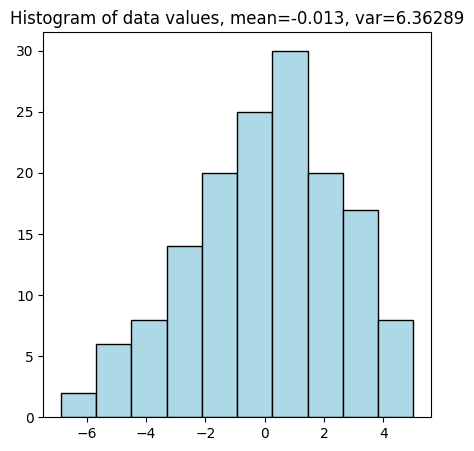

In [12]:
# Plot histogram of data values
plt.figure(figsize=(5,5))
plt.hist(v, color='lightblue', edgecolor='black')
plt.title('Histogram of data values, mean={:.2g}, var={:2g}'.format(np.mean(v), np.var(v)))
plt.show()

In the following steps, one assumes that the bi-point statistics is omni-directional (same in any direction), then omni-directional analysis is done.

### Omni-directional  variogram cloud
The function `geone.covModel.variogramCloud1D` is used (see jupyter notebook `ex_vario_analysis_data1D`).

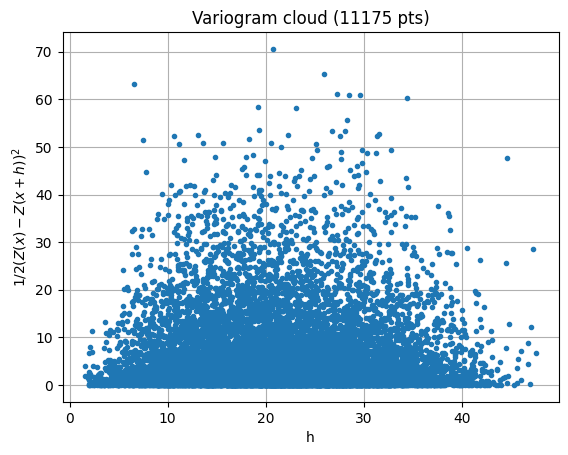

In [13]:
h, g, npair = gn.covModel.variogramCloud1D(x, v)

### Omni-directional experimental variogram
The function `geone.covModel.variogramExp1D` is used (see jupyter notebook `ex_vario_analysis_data1D`).

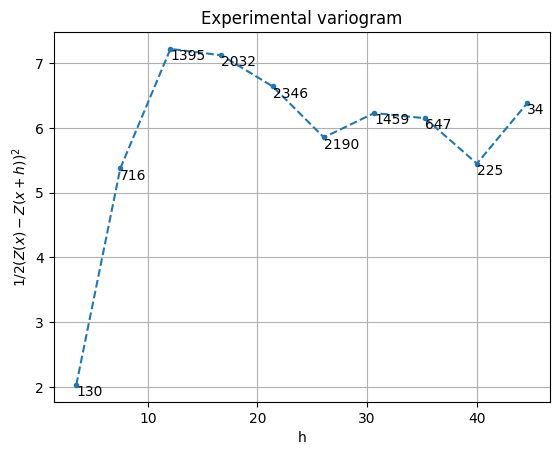

In [14]:
hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v)
# hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v, variogramCloud=(g, h, npair)) # equivalent (x, v not used) 

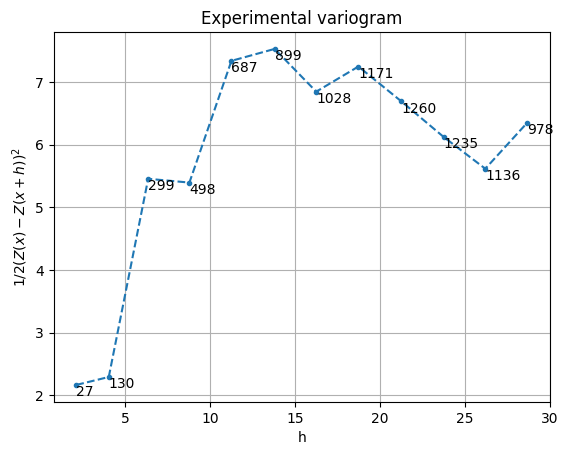

In [15]:
hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v, hmax=30, ncla=12)

### Omni-directional model fitting
The function `geone.covModel.covModel1D_fit` is used to fit a covariance model in 1D (class `geone.covModel.CovModel1D`) (see jupyter notebook `ex_vario_analysis_data1D`).

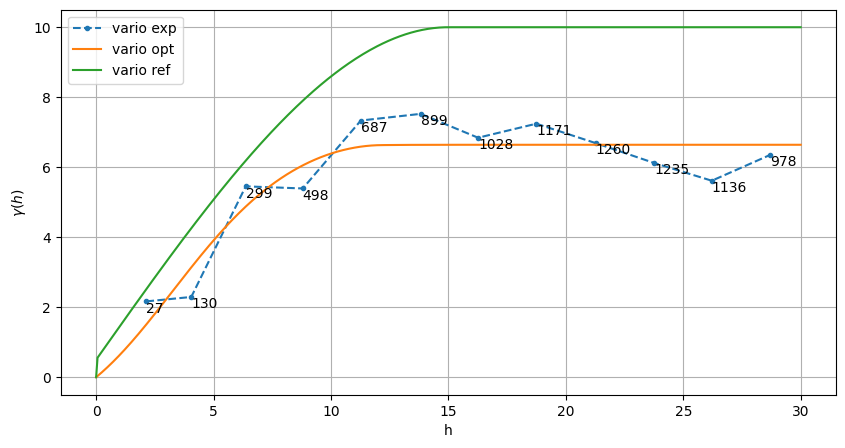

*** CovModel1D object ***
name = ''
number of elementary contribution(s): 4
elementary contribution 0
    type: gaussian
    parameters:
        w = 2.1333804897770787
        r = 9.043448172435706
elementary contribution 1
    type: spherical
    parameters:
        w = 4.508014958345524
        r = 12.134830189552105
elementary contribution 2
    type: exponential
    parameters:
        w = 9.009041749147105e-05
        r = 5.558859353309096
elementary contribution 3
    type: nugget
    parameters:
        w = 7.99529022088765e-08
*****

In [16]:
cov_model_to_optimize = gn.covModel.CovModel1D(
    elem=[('gaussian',    {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('spherical',   {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('exponential', {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('nugget',      {'w':np.nan})              # elementary contribution
         ], name='')

hmax = 30
cov_model_opt, popt = gn.covModel.covModel1D_fit(x, v, cov_model_to_optimize, hmax=hmax,
                                         bounds=([ 0,   0, 0,  0,  0,  0,  0],  # min value for param. to fit
                                                 [20, 30, 20, 30, 30, 30, 20]), # max value for param. to fit
                                         make_plot=False)
plt.figure(figsize=(10,5))
gn.covModel.plot_variogramExp1D(hexp, gexp, cexp, label='vario exp')
cov_model_opt.plot_model(vario=True, hmax=hmax, label='vario opt') # cov. model in 1D
cov_model_ref.plot_model(vario=True, hmax=hmax, label='vario ref') # cov. model in 1D
plt.legend()
plt.show()
cov_model_opt

### Cross-validation of covariance model by leave-one-out error
The function `geone.covModel.cross_valid_loo` makes a cross-validation test by leave-one-out (LOO) error. 

For a given a data set (in 3D) and a covariance model in 1D, this latter defines an omni-directional covariance model.

See jupyter notebook `ex_vario_analysis_data1D` for more details about this function.

----- CRPS (negative; the larger, the better) -----
   mean = -0.9358
   def. = -0.5895
----- 1) "Normal law test for mean of normalized error" -----
   p-value = 0.9955
   success = True (wrt significance level 0.05)
      (-> model has no reason to be rejected)
----- 2) "Chi-square test for sum of squares of normalized error" -----
   p-value = 0.8867
   success = True (wrt significance level 0.05)
      (-> model has no reason to be rejected)
----- Statistics of normalized error -----
   mean     = 0.0004619 (should be close to 0)
   std      = 0.9288 (should be close to 1)
   skewness = 0.04562 (should be close to 0)
   excess kurtosis = -0.05457 (should be close to 0)


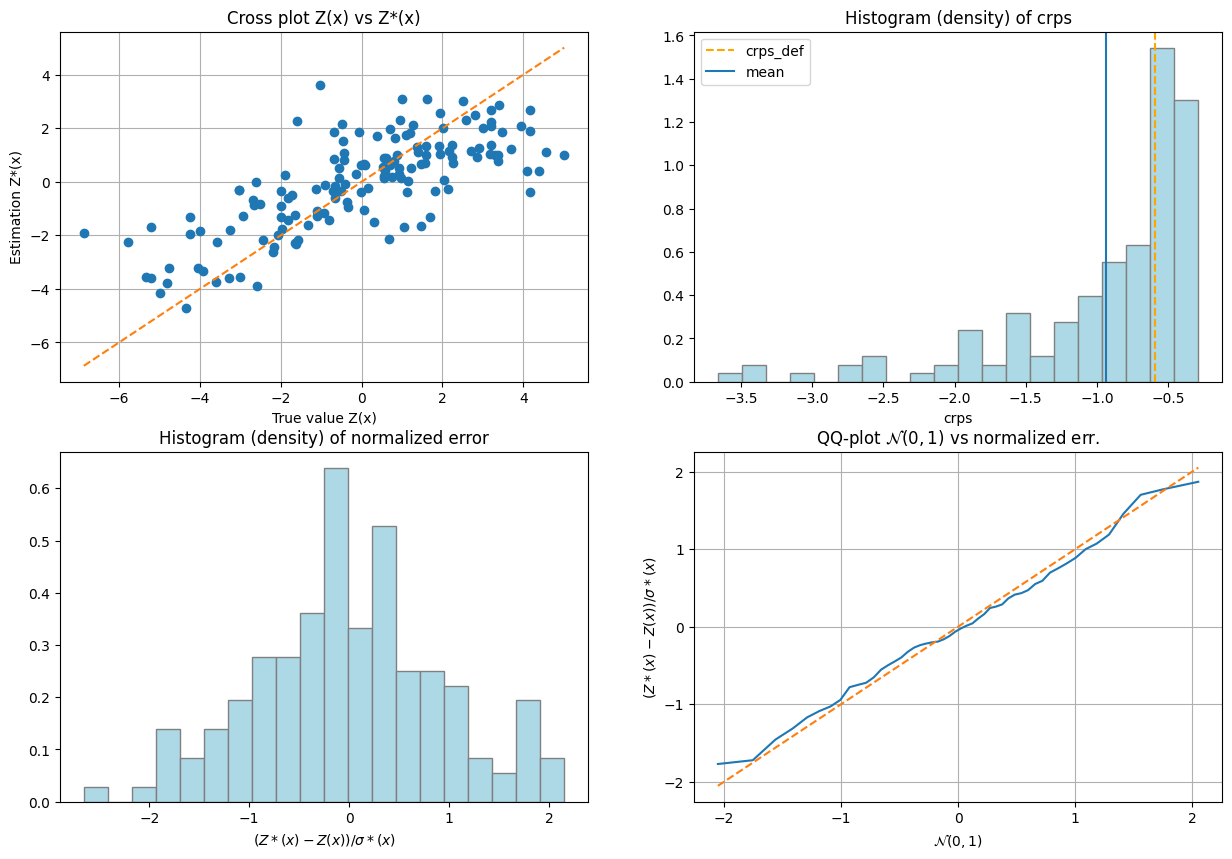

In [17]:
# Interpolation by simple kriging
cv_est1, cv_std1, crps1, crps_def1, pvalue1, success1 = gn.covModel.cross_valid_loo(
                                        x, v, cov_model_opt,
                                        interpolator=gn.covModel.krige,
                                        interpolator_kwargs={'method':'ordinary_kriging'},
                                        print_result=True, make_plot=True, figsize=(15,10), nbins=20)
plt.show()

If one test failed (or if the covariance model does not display the desired shape), the covariance model should be rejected and the search for a convenient covariance model be pursued.

## Data interpolation by (simple or ordinary) kriging: function `geone.covModel.krige`
See notebook `ex_vario_analysis_data1D_1.ipynb`.


In [18]:
# Define points xu where to interpolate
# ... location of the 3D-grid used to build the data set (but it could be different)
xcu = ox + (np.arange(nx)+0.5)*sx # x-coordinates of points
ycu = oy + (np.arange(ny)+0.5)*sy # y-coordinates of points
zcu = oz + (np.arange(nz)+0.5)*sz # z-coordinates of points
zzcu, yycu, xxcu = np.meshgrid(zcu, ycu, xcu, indexing='ij')
xu = np.array((xxcu.reshape(-1), yycu.reshape(-1), zzcu.reshape(-1))).T # 2-dimensional array 
                                                                        # of shape nx*ny*nz x 3

# Ordinary kriging
t1 = time.time() # start time
vu, vu_std = gn.covModel.krige(x, v, xu, cov_model_opt, method='ordinary_kriging', use_unique_neighborhood=True)
# vu:     1-dimensional array, kriging estimates at location xu
# vu_std: 1-dimensional array, kriging standard deviation at location xu
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.4g} sec')

# Fill image (Img class from geone.img) for view
#   variable 0: kriging estimates
#   variable 1: kriging standard deviation
im_krig = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=2, val=np.array((vu, vu_std)))

Elapsed time: 2.259 sec


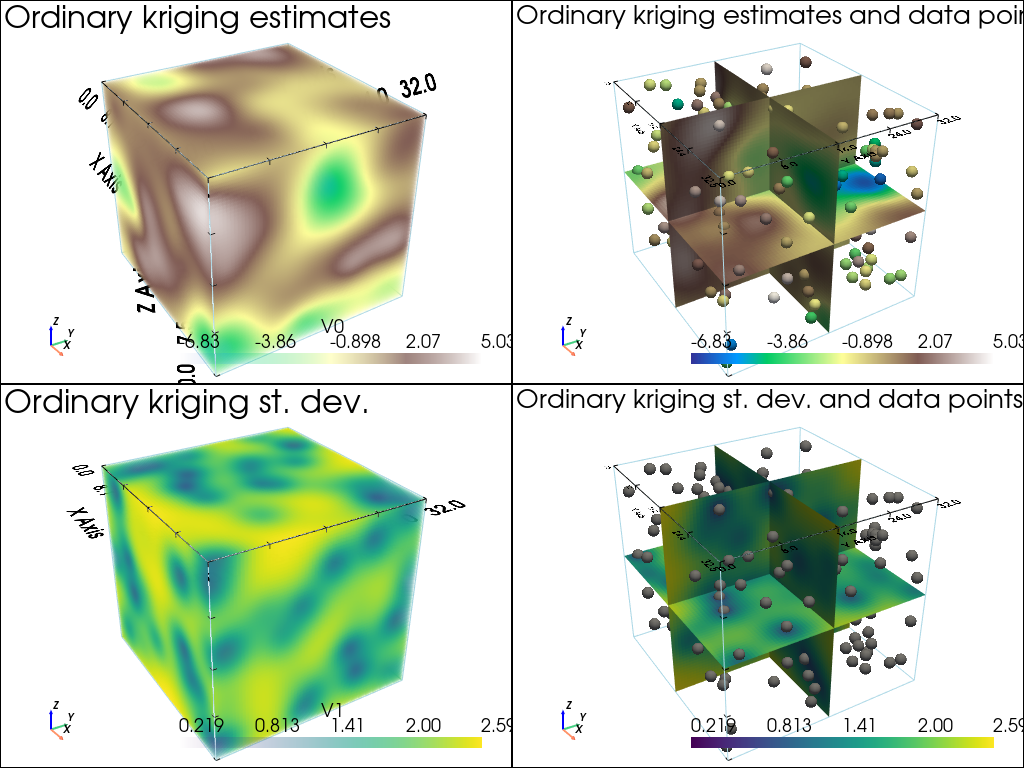

In [19]:
# Color settings
cmap = 'terrain'

cmin = im_krig.vmin()[0] # min value of kriging estimates
cmax = im_krig.vmax()[0] # max value of kriging estimates

# Get colors for conditioning data according to their value and color settings
data_points_col = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin, cmax=cmax) 

# Set points to be plotted
data_points = pv.PolyData(x)
data_points['colors'] = data_points_col

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_volume(
    im_krig, iv=0, 
    plotter=pp, 
    cmap=cmap, cmin=cmin, cmax=cmax,
    show_bounds=True, # show axes and ticks around the 3D box
    text='Ordinary kriging estimates') # title

pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_slice(
    im_krig, iv=0, 
    plotter=pp,
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap=cmap, cmin=cmin, cmax=cmax,
    show_bounds=True, # show axes and ticks around the 3D box
    scalar_bar_kwargs={'title':''}, # distinct title in each subplot for correct display!
    text='Ordinary kriging estimates and data points') # title                          
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_volume(
    im_krig, iv=1, 
    plotter=pp, 
    cmap='viridis',
    show_bounds=True, # show axes and ticks around the 3D box
    text='Ordinary kriging st. dev.') # title

pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    im_krig, iv=1, 
    plotter=pp,
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap='viridis',
    show_bounds=True, # show axes and ticks around the 3D box
    scalar_bar_kwargs={'title':' '}, # distinct title in each subplot for correct display!
    text='Ordinary kriging st. dev. and data points') # title                          
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

In [20]:
# Define points xu where to interpolate
# ... location of the 3D-grid used to build the data set (but it could be different)
xcu = ox + (np.arange(nx)+0.5)*sx # x-coordinates of points
ycu = oy + (np.arange(ny)+0.5)*sy # y-coordinates of points
zcu = oz + (np.arange(nz)+0.5)*sz # z-coordinates of points
zzcu, yycu, xxcu = np.meshgrid(zcu, ycu, xcu, indexing='ij')
xu = np.array((xxcu.reshape(-1), yycu.reshape(-1), zzcu.reshape(-1))).T # 2-dimensional array 
                                                                        # of shape nx*ny*nz x 3

# Simple kriging
t1 = time.time() # start time
vu, vu_std = gn.covModel.krige(x, v, xu, cov_model_opt, method='simple_kriging', use_unique_neighborhood=True)
# vu:     1-dimensional array, kriging estimates at location xu
# vu_std: 1-dimensional array, kriging standard deviation at location xu
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.4g} sec')

# Fill image (Img class from geone.img) for view
#   variable 0: kriging estimates
#   variable 1: kriging standard deviation
im_krig = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=2, val=np.array((vu, vu_std)))

Elapsed time: 2.491 sec


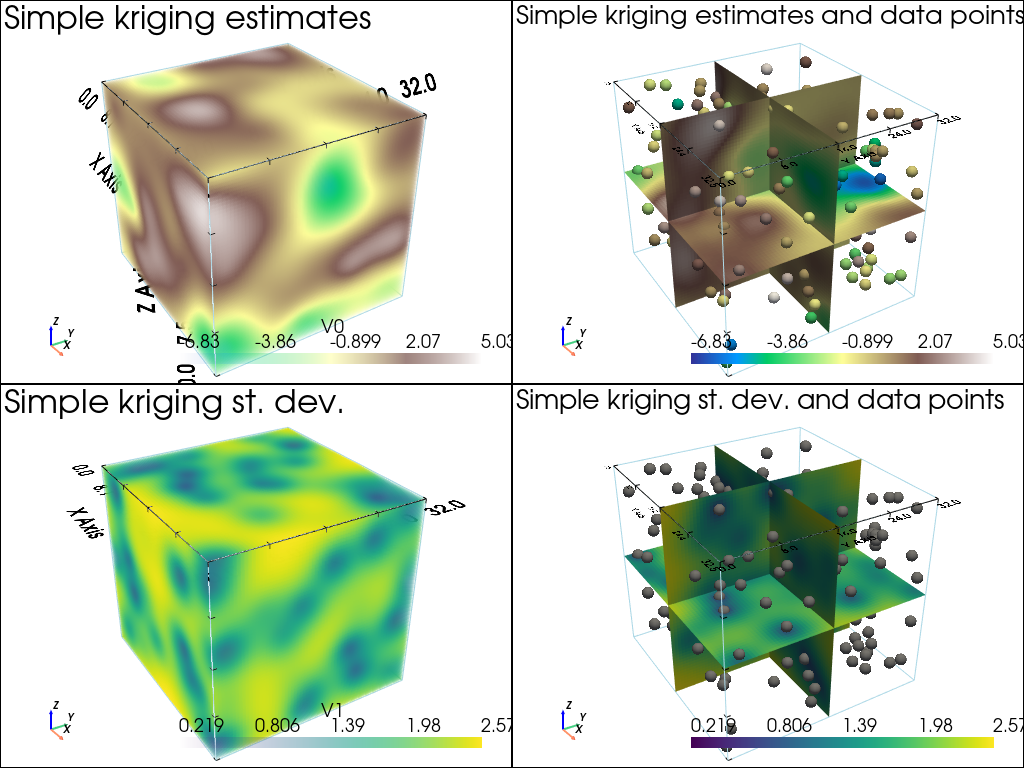

In [21]:
# Color settings
cmap = 'terrain'

cmin = im_krig.vmin()[0] # min value of kriging estimates
cmax = im_krig.vmax()[0] # max value of kriging estimates

# Get colors for conditioning data according to their value and color settings
data_points_col = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin, cmax=cmax) 

# Set points to be plotted
data_points = pv.PolyData(x)
data_points['colors'] = data_points_col

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_volume(
    im_krig, iv=0, 
    plotter=pp, 
    cmap=cmap, cmin=cmin, cmax=cmax,
    show_bounds=True, # show axes and ticks around the 3D box
    text='Simple kriging estimates') # title

pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_slice(
    im_krig, iv=0, 
    plotter=pp, 
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap=cmap, cmin=cmin, cmax=cmax,
    show_bounds=True, # show axes and ticks around the 3D box
    scalar_bar_kwargs={'title':''}, # distinct title in each subplot for correct display!
    text='Simple kriging estimates and data points') # title                          
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_volume(
    im_krig, iv=1, 
    plotter=pp, 
    cmap='viridis',
    show_bounds=True, # show axes and ticks around the 3D box
    text='Simple kriging st. dev.') # title

pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    im_krig, iv=1, 
    plotter=pp, 
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap='viridis',
    show_bounds=True, # show axes and ticks around the 3D box
    scalar_bar_kwargs={'title':' '}, # distinct title in each subplot for correct display!
    text='Simple kriging st. dev. and data points') # title                          
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

## Kriging estimation and simulation in a grid
The function above (`gn.covModel.krige` and `gn.covModel.sgs[_mp]`) should not be used for kriging and SGS in a regular grid. Use the dedicated functions (much faster):
- `geone.geosclassicinterface.estimate`: estimation (kriging) in a grid
- `geone.geosclassicinterface.simulate`: simulation (SGS) in a grid
- `geone.grf.krige<d>D`: estimation (kriging) in a `<d>`-dimensional grid
- `geone.grf.grf<d>D`: simulation (SGS) in a `<d>`-dimensional grid

*Note: the functions of the module `geone.grf` are based on "Fast Fourier Transform" and allow for simple kriging only, and do not handle error on data or inequality data.*

*Note: the function `geone.multiGaussian.multiGaussianRun` can be used as a wrapper to run the functions above.*

See notebook `ex_vario_analysis_data1D_1.ipynb`.

## Examples

### Estimation using the function `geone.covModel.krige`

In [22]:
t1 = time.time()
vu, vu_std = gn.covModel.krige(x, v, xu, cov_model_opt, method='simple_kriging', use_unique_neighborhood=True)
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

Elapsed time: 2.5 sec


### Estimation using the function `geone.grf.krige3D`
Via the function `geone.multiGaussian.multiGaussianRun`, with keyword arguments `mode='estimation', algo='fft'`.

In [23]:
t1 = time.time()
im_grf = gn.multiGaussian.multiGaussianRun(
                cov_model_opt, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz), 
                x=x, v=v,
                mode='estimation', algo='fft', output_mode='img')
# # Or:
# vu_grf, vu_std_grf = gn.grf.krige3D(
#                 cov_model_opt, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz), 
#                 x=x, v=v)
# im_grf = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=2, val=np.array((vu_grf, vu_std_grf)))
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krige3D: Computing circulant embedding...
krige3D: embedding dimension: 128 x 128 x 64
krige3D: Computing FFT of circulant matrix...
krige3D: Computing covariance matrix (rAA) for conditioning locations...
krige3D: Computing covariance matrix (rBA) for non-conditioning / conditioning locations...
krige3D: Computing rBA * rAA^(-1)...
krige3D: computing kriging estimates...
krige3D: computing kriging standard deviation ...
Elapsed time: 1.9 sec


### Estimation using the function `geone.geosclassicinterface.estimate`
Via the function `geone.multiGaussian.multiGaussianRun`, with keyword arguments `mode='estimation', algo='classic'`.

In [24]:
t1 = time.time()
im_gci = gn.multiGaussian.multiGaussianRun(
                cov_model_opt, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz), 
                x=x, v=v,
                mode='estimation', algo='classic', output_mode='img',
                method='simple_kriging', 
                nneighborMax=24,
                nthreads=8)
# # Or:
# estim_gci = gn.geosclassicinterface.estimate(
#                 cov_model_opt, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz), 
#                 x=x, v=v,
#                 method='simple_kriging', 
#                 nneighborMax=24,
#                 nthreads=8)
# im_gci = estim_gci['image']
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

estimate: Preprocessing data done: final number of data points : 150, inequality data points: 0
estimate: Computational resources: nthreads = 8, nproc_sgs_at_ineq = 8
estimate: (Step 1) No inequality data
estimate: (Step 2) Set new dataset gathering data and inequality data locations...
estimate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
estimate: (Step 4) Do kriging on the grid (at cell centers) using data points at cell centers...
estimate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
estimate: Geos-Classic (1 process) run complete
Elapsed time: 20 sec


### Plot results of estimation

In [25]:
# Fill images (Img class from geone.img) for view
#   variable 0: kriging estimates
#   variable 1: kriging standard deviation
im_krig = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=2, val=np.array((vu, vu_std)))

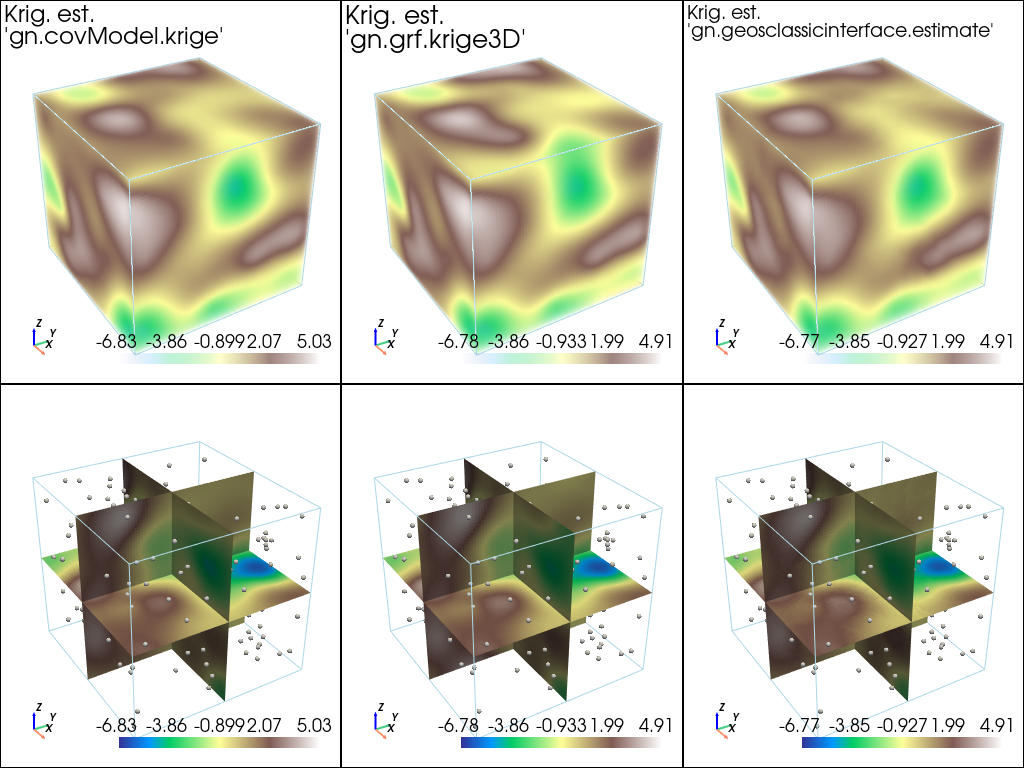

In [26]:
# Plot kriging estimates

# Color settings
cmap = 'terrain'

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,3), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,3))

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_volume(
    im_krig, iv=0, 
    plotter=pp, 
    cmap=cmap,
    scalar_bar_kwargs={'title':''}, # distinct title in each subplot for correct display!
    text="Krig. est.\n'gn.covModel.krige'", # title
    text_kwargs={'font_size':14}) # font size for title

pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_volume(
    im_grf, iv=0, 
    plotter=pp, 
    cmap=cmap,
    scalar_bar_kwargs={'title':' '}, # distinct title in each subplot for correct display!
    text="Krig. est.\n'gn.grf.krige3D'", # title
    text_kwargs={'font_size':14}) # font size for title

pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_volume(
    im_gci, iv=0, 
    plotter=pp, 
    cmap=cmap,
    scalar_bar_kwargs={'title':'  '}, # distinct title in each subplot for correct display!
    text="Krig. est.\n'gn.geosclassicinterface.estimate'", # title
    text_kwargs={'font_size':14}) # font size for title

pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_slice(
    im_krig, iv=0, 
    plotter=pp, 
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap=cmap,
    scalar_bar_kwargs={'title':'   '}, # distinct title in each subplot for correct display!
    text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    im_grf, iv=0, 
    plotter=pp, 
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap=cmap,
    scalar_bar_kwargs={'title':'    '}, # distinct title in each subplot for correct display!
    text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_slice(
    im_gci, iv=0, 
    plotter=pp, 
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap=cmap,
    scalar_bar_kwargs={'title':'     '}, # distinct title in each subplot for correct display!
    text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

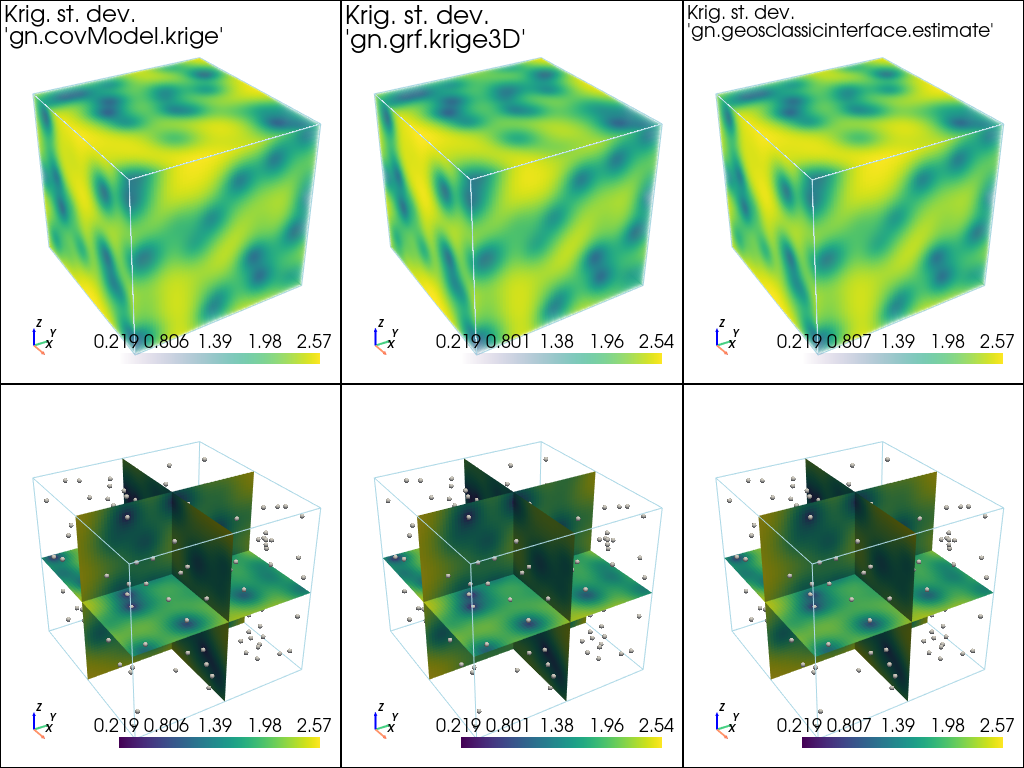

In [27]:
# Plot kriging standard deviation

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,3), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,3))

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_volume(
    im_krig, iv=1, 
    plotter=pp, 
    cmap='viridis',
    scalar_bar_kwargs={'title':''}, # distinct title in each subplot for correct display!
    text="Krig. st. dev.\n'gn.covModel.krige'", # title
    text_kwargs={'font_size':14}) # font size for title

pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_volume(
    im_grf, iv=1, 
    plotter=pp, 
    cmap='viridis',
    scalar_bar_kwargs={'title':' '}, # distinct title in each subplot for correct display!
    text="Krig. st. dev.\n'gn.grf.krige3D'", # title
    text_kwargs={'font_size':14}) # font size for title

pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_volume(
    im_gci, iv=1, 
    plotter=pp, 
    cmap='viridis',
    scalar_bar_kwargs={'title':'  '}, # distinct title in each subplot for correct display!
    text="Krig. st. dev.\n'gn.geosclassicinterface.estimate'", # title
    text_kwargs={'font_size':14}) # font size for title

pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_slice(
    im_krig, iv=1, 
    plotter=pp,
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap='viridis',
    scalar_bar_kwargs={'title':'   '}, # distinct title in each subplot for correct display!
    text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    im_grf, iv=1, 
    plotter=pp, 
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap='viridis',
    scalar_bar_kwargs={'title':'    '}, # distinct title in each subplot for correct display!
    text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_slice(
    im_gci, iv=1, 
    plotter=pp, 
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap='viridis',
    scalar_bar_kwargs={'title':'     '}, # distinct title in each subplot for correct display!
    text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

In [28]:
print("Peak-to-peak estimation 'gn.covModel.krige - gn.grf.krige3D'                   = {}".format(np.ptp(im_krig.val[0] - im_grf.val[0])))
print("Peak-to-peak estimation 'gn.covModel.krige - gn.geosclassicinterface.estimate' = {}".format(np.ptp(im_krig.val[0] - im_gci.val[0])))
print("Peak-to-peak estimation 'gn.grf.krige3D    - gn.geosclassicinterface.estimate' = {}".format(np.ptp(im_grf.val[0] - im_gci.val[0])))
print("Peak-to-peak st. dev.   'gn.covModel.krige - gn.grf.krige3D'                   = {}".format(np.ptp(im_krig.val[1] - im_grf.val[1])))
print("Peak-to-peak st. dev.   'gn.covModel.krige - gn.geosclassicinterface.estimate' = {}".format(np.ptp(im_krig.val[1] - im_gci.val[1])))
print("Peak-to-peak st. dev.   'gn.grf.krige3D    - gn.geosclassicinterface.estimate' = {}".format(np.ptp(im_grf.val[1] - im_gci.val[1])))

Peak-to-peak estimation 'gn.covModel.krige - gn.grf.krige3D'                   = 3.9329387486203378
Peak-to-peak estimation 'gn.covModel.krige - gn.geosclassicinterface.estimate' = 2.0258586350203265
Peak-to-peak estimation 'gn.grf.krige3D    - gn.geosclassicinterface.estimate' = 4.180550548317362
Peak-to-peak st. dev.   'gn.covModel.krige - gn.grf.krige3D'                   = 0.9922335217643207
Peak-to-peak st. dev.   'gn.covModel.krige - gn.geosclassicinterface.estimate' = 0.4616521097608721
Peak-to-peak st. dev.   'gn.grf.krige3D    - gn.geosclassicinterface.estimate' = 0.7637757109552673


### Conditional simulation using the function `geone.grf.grf3D`
Via the function `geone.multiGaussian.multiGaussianRun`, with keyword arguments `mode='simulation', algo='fft'`.

In [29]:
np.random.seed(293)

t1 = time.time()
nreal = 20
im_sim_grf = gn.multiGaussian.multiGaussianRun(
                    cov_model_opt, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz), 
                    x=x, v=v, 
                    mode='simulation', algo='fft', output_mode='img',
                    nreal=nreal)
# # Or:
# sim_grf = gn.grf.grf3D(
#                     cov_model_opt, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz), 
#                     x=x, v=v, 
#                     nreal=nreal)
# im_sim_grf = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=nreal, val=sim_grf)
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

grf3D: Preliminary computation...
grf3D: Computing circulant embedding...
grf3D: embedding dimension: 128 x 128 x 64
grf3D: Computing FFT of circulant matrix...
grf3D: Treatment of conditioning data...
grf3D: Computing covariance matrix (rAA) for conditioning locations...
grf3D: Computing index in the embedding grid for non-conditioning / conditioning locations...
Elapsed time: 4.5 sec


### Conditional simulation using the function `geone.geosclassicinterface.simulate`
Via the function `geone.multiGaussian.multiGaussianRun`, with keyword arguments `mode='simulation', algo='classic'`, and specifying the computational resources (`nproc` and `nthreads_per_proc`).

In [30]:
np.random.seed(293)

t1 = time.time()
nreal = 20
im_sim_gci = gn.multiGaussian.multiGaussianRun(
                    cov_model_opt, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz), 
                    x=x, v=v, 
                    mode='simulation', algo='classic', output_mode='img',
                    method='simple_kriging', 
                    nreal=nreal,
                    nproc=2, nthreads_per_proc=4)
# # Or:
# sim_gci = gn.geosclassicinterface.simulate(
#                     cov_model_opt, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz), 
#                     x=x, v=v, 
#                     method='simple_kriging', 
#                     nreal=nreal, 
#                     nproc=4, nthreads_per_proc=4)
# im_sim_gci = sim_gci['image']
t2 = time.time()
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simulate: Preprocessing data done: final number of data points : 150, inequality data points: 0
simulate: Computational resources: nproc = 2, nthreads_per_proc = 4, nproc_sgs_at_ineq = 8
simulate: (Step 1) No inequality data
simulate: (Step 2) Set new dataset gathering data and inequality data locations...
simulate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
simulate: (Step 4) Do sgs (20 realizations) on the grid (at cell centers) using data points at cell centers...
simulate: Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
run_MPDSOMPGeosClassicSim [pid=0]: Geos-Classic run complete
simulate: Geos-Classic (2 process(es)) run complete
Elapsed time: 7.2 sec


### Plot some realizations and compare to the reference simulation

In [31]:
# min and max over all real and ref. sim
im_vmin = min(np.min(im_sim_grf.vmin()), np.min(im_sim_gci.vmin()), im_ref.vmin()[0]) 
im_vmax = max(np.max(im_sim_grf.vmax()), np.min(im_sim_gci.vmax()), im_ref.vmax()[0])

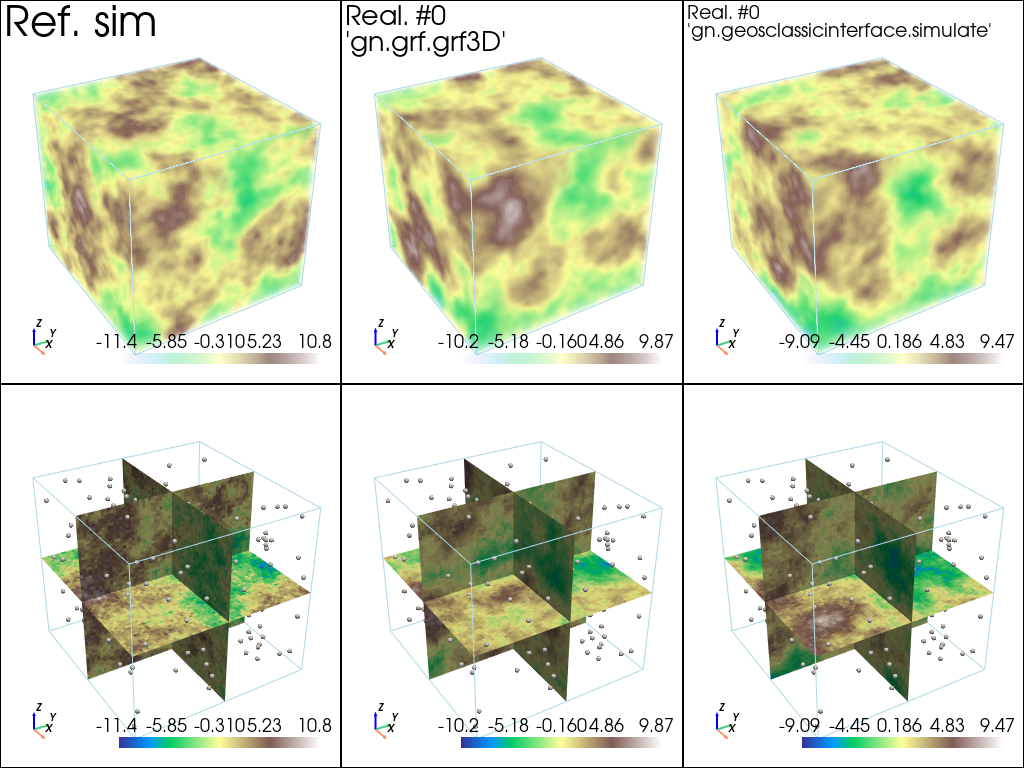

In [32]:
# Color settings
cmap = 'terrain'

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,3), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,3))

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_volume(
    im_ref, iv=0, 
    plotter=pp, 
    cmap=cmap,
    scalar_bar_kwargs={'title':''}, # distinct title in each subplot for correct display!
    text="Ref. sim") # title

pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_volume(
    im_sim_grf, iv=0, 
    plotter=pp,
    cmap=cmap,
    scalar_bar_kwargs={'title':' '}, # distinct title in each subplot for correct display!
    text="Real. #0\n'gn.grf.grf3D'", # title
    text_kwargs={'font_size':14}) # font size for title

pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_volume(
    im_sim_gci, iv=0, 
    plotter=pp, 
    cmap=cmap,
    scalar_bar_kwargs={'title':'  '}, # distinct title in each subplot for correct display!
    text="Real. #0\n'gn.geosclassicinterface.simulate'", # title
    text_kwargs={'font_size':14}) # font size for title

pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_slice(
    im_ref, iv=0, 
    plotter=pp, 
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap=cmap,
    scalar_bar_kwargs={'title':'   '}, # distinct title in each subplot for correct display!
    text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    im_sim_grf, iv=0, 
    plotter=pp, 
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap=cmap,
    scalar_bar_kwargs={'title':'    '}, # distinct title in each subplot for correct display!
    text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_slice(
    im_sim_gci, iv=0, 
    plotter=pp, 
    slice_normal_x=ox+(0.5+nx//2)*sx, # near central cell along x
    slice_normal_y=oy+(0.5+ny//2)*sy, # near central cell along y
    slice_normal_z=oz+(0.5+nz//2)*sz, # near central cell along z
    cmap=cmap,
    scalar_bar_kwargs={'title':'     '}, # distinct title in each subplot for correct display!
    text=None) # title                          
pp.add_mesh(data_points, color=(0.9, 0.9, 0.9), point_size=5., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified